<a href="https://colab.research.google.com/github/ArnaudGardille/Carla-4-Causality/blob/main/Conformal_Anomaly_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README
Author: Matthew P. Burruss
Copyright 2020, all rights reserved

An example of a simple conformal anomaly detector built on the conformal predictor framework

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Data generator
A class to create our fake data set

In [2]:
class DataGenerator():
    """
        Fake data generator that generates data along an n-dimensional hypercube. By default, 2-dimensional hypercube is used. Within-class variation
        achieved by simply adding Gaussian noise.
        @params
            num_classes: int
                The number of classes to generate
            num_samples_per_class: int
                The number of samples to generate per class (total samples = num_classes*num_samples_per_class)
            num_features: int
                The number of features to generate. Note: This can only be visualized if num_features = 2
            minFeature: int
                The minimum of our hyper-cube along each dimension
            maxFeature: int
                The maximum of our hyper-cube along each dimension
    """
    def __init__(self,num_classes=10,num_samples_per_class=100,num_features = 2,minFeature=0,maxFeature=50):
        self._num_classes = num_classes
        self._num_features = num_features
        self._num_samples_per_class = num_samples_per_class
        self._minFeature = minFeature
        self._maxFeature = maxFeature
        self.x = np.zeros((self._num_classes*self._num_samples_per_class,self._num_features))
        self.y = np.zeros((self._num_classes*self._num_samples_per_class,1))
        self._list_of_funcs = []
        for i in range(self._num_classes):
            features = np.random.randint(self._minFeature,self._maxFeature,(1,self._num_features)).astype(np.float64)
            noise = np.random.rand(self._num_samples_per_class,self._num_features)*6 # add some noise to the features
            features = features + noise
            self._list_of_funcs.append(features)
            self.x[i*self._num_samples_per_class:(i+1)*self._num_samples_per_class] = features
            self.y[i*self._num_samples_per_class:(i+1)*self._num_samples_per_class] = int(i)

    """
        Create a scatter plot of mx2 data with label in y for legend creation and title
        @params
            x: np.ndarray
                A mx2 array with m samples where containing x axis and y axis scatter plot data
            y: np.ndarray
                A m array of labels
            title: str
                The title of the scatter plot
        @return
            The generated plot in case you want to plot over it
    """
    def create_scatter_plot(self,x,y,title):
        assert x.shape[1] == 2,\
            print('Cannot create a scatter plot of data with {} features'.format(x.shape[1]))
        fig, ax = plt.subplots()
        scatter = ax.scatter(x[:,0], x[:,1], c=np.squeeze(y),alpha=0.3)
        legend1 = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend1)
        plt.title(title)
        return plt

    """
        Generates data randomly across n-dimensional hypercube
        @params
            num_anomalies: int
                The number of anomalies to create
        @return: np.ndarray
            A num_anomalies x num_features array of the anomalies
    """
    def create_anomaly(self,num_anomalies):
        anomalies = np.random.randint(self._minFeature,self._maxFeature,(num_anomalies,self._num_features))
        return anomalies

    """
        Displays the anomolous data over the fake data set. Anomalies are displayed by a red cross and non-anomalies displayed by blue cross
        @params
            anomalies: np.ndarray
                An mxnum_features array
            isAnomaly: np.ndarray
                An mx1 boolean array indicating if the i'th sample is an anomaly or not
            block: bool
                Whether or not the plot will block further code execution
            title: str
                The title of the plot
    """
    def showAnomalies(self,anomalies,isAnomaly,block=False,title=''):
        self.plt = self.create_scatter_plot(self.x,self.y,title=title)
        yes_anomaly = anomalies[isAnomaly]
        not_anomaly = anomalies[np.invert(isAnomaly)]
        self.plt.scatter(yes_anomaly[:,0],yes_anomaly[:,1],marker='x',c='r',s=plt.rcParams['lines.markersize']**2.5,label='anomaly')
        self.plt.scatter(not_anomaly[:,0],not_anomaly[:,1],marker='x',c='b',s=plt.rcParams['lines.markersize']**2.5,label='not_anomaly')
        self.plt.legend()
        self.plt.show(block=block)

# K-Nearest Neighbor
A simple way to calculate a conformal predictor score

In [3]:
class KNearestNeighbors():
    """
        A simple real-valued function to compute the conformal scores
        Each conformal score is the average k-nearest neighbors according to a specified metric
        @params
            k: int
                Determines k nearest neighbors
            metric: str
                distance metric (see scipy's pdist function for valid metrics)
    """
    def __init__(self,k,metric='euclidean'):
        self._k = k
        self._metric = metric

    """
        Returns a pairwise distance matrix
        @params
            x: np.ndarray
                An m x n array with m samples and n dimensions
    """
    def get_pairwise_distance_matrix(self,x):
        distances = pdist(x,self._metric)
        distance_matrix = squareform(distances)
        return distance_matrix

    """
        Returns the mean pairwise distance between the k'th nearest neighbors
        @params
            x: np.ndarray
                An m x n array with m samples and n dimensions
    """
    def __call__(self,x):
        distance_matrix = self.get_pairwise_distance_matrix(x)
        distance_matrix = np.sort(distance_matrix,axis=1)
        assert self._k +1 < distance_matrix.shape[1],\
            print('K must be less than the number of data points (k={},num_samples={})'.format(self._k +1,distance_matrix.shape[1]))
        return np.mean(distance_matrix[:,1:self._k+1],axis=1)

# Conformal Anomaly Detector (CAD)

In [4]:
class ConformalAnomalyDetector():
    """
    Conformal Anomaly Detector Class
    @params
        ICM: class
            An object whose call operation should produce an array of conformal scores
        z: tuple (len==2)
            Each element is an (x,y) pair of the training set for CAD
        significance: float
            The significance level (must be between 0 and 1 exclusive)
    """
    def __init__ (self,ICM,z,significance=0.05):
        self._ICM = ICM
        self.x = z[0]
        self.y = z[1]
        assert significance > 0 and significance < 1, \
            print('Significance must be in range (0,1).')
        self._significance = significance
        
    """
    Return true or false if the test example are an anomaly
    @params
        test: np.ndarray
            A 1xn test example where m is the number of test examples and n is the number of dimensions
    @return: bool
        True if test input is anomaly and false otherwise 
    """
    def testIfAnomaly(self,test):
        conformal_set = np.concatenate((self.x,test))
        conformal_scores = self._ICM(conformal_set)
        p = np.sum(conformal_scores >= conformal_scores[-1]) / (len(self.y)+1)
        return p < self._significance

    """
    Return array of true or false if the test examples are an anomaly
    @params
        test: np.ndarray
            A mxn test example where m is the number of test examples and n is the number of dimensions
    @return: np.ndarray
        An mx1 array of true if test input is anomaly and false otherwise 
    """ 
    def __call__(self,anomalies):
        isAnomaly = [self.testIfAnomaly(np.expand_dims(anomalies[i],axis=0)) for i in range(anomalies.shape[0])]
        return isAnomaly

    """
    Change significance level (hyper-parameter)
    @params
        significance: float
            The significance level (must be between 0 and 1 exclusive)
    """ 
    def set_significance(self,significance):
        assert significance > 0 and significance < 1, \
            print('Significance must be in range (0,1).')
        self._significance = significance

# Main

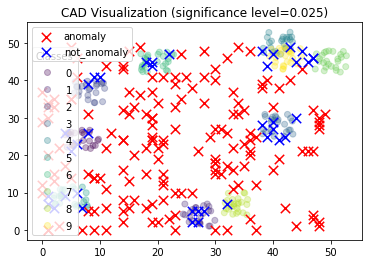

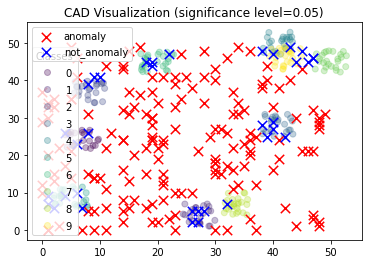

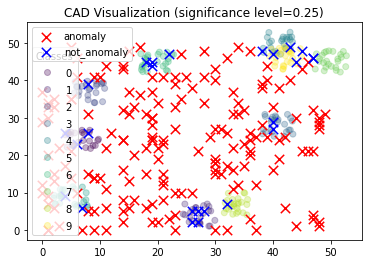

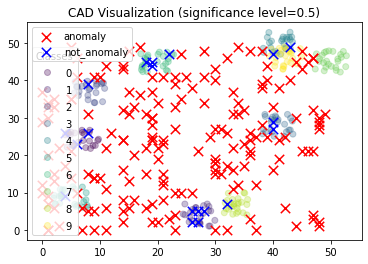

In [5]:
def main():
    np.random.seed(123432) # set seed for reproducibility
    data_generator = DataGenerator(num_samples_per_class=25) # create 10 classes each with 25 samples
    k_nearest_neighbor = KNearestNeighbors(k=10) # Initialize the ICM that uses k-nearest neighbors(k=10)
    conformal_predictor = ConformalAnomalyDetector(ICM=k_nearest_neighbor,z=(data_generator.x,data_generator.y)) # initialize CAD
    anomalies = data_generator.create_anomaly(200) # Generate 200 anomalies

    significances = [0.025,0.05,0.25,0.5] # see how different significance levels affect results
    for i in range(len(significances)):
        significance = significances[i]
        conformal_predictor.set_significance(significance) # change significance
        isAnomaly = conformal_predictor(anomalies) # test if anomamlies according to current CAD
        title = 'CAD Visualization (significance level={})'.format(significance)
        data_generator.showAnomalies(anomalies,isAnomaly,block = i==len(significances)-1,title=title) # plot results

if __name__ == '__main__':
    main()